In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import utils

from utils import total_variation_distance
from scipy.stats import multivariate_normal as mv_norm
%matplotlib inline

# Metropolis-Adjusted Langevin

In [7]:
def mala(X, dX, init_func, num_samples, delta=1.2, step=1):
    K = lambda q: 0.5 * (q.T @ q)
    result = np.array([init_func()], dtype=np.float64)
    dim, a = len(result[0]), 0
    for x in range(num_samples):
        start_pos = np.copy(result[-1])
        unscaled_brownian = mv_norm.rvs(cov=np.eye(dim))
        proposed = start_pos - (delta**2) * dX(start_pos) / 2 + delta * unscaled_brownian

        alpha = np.exp(-X(proposed) + K(unscaled_brownian) + X(start_pos) -
                       K(unscaled_brownian - delta / 2 * (dX(start_pos) + dX(proposed))) )
        a += min(1, alpha)
        next_state = proposed if stats.bernoulli.rvs(min(1, alpha), size=1) else start_pos
        result = np.append(result, [next_state], axis=0)
    return result[::step], a / num_samples

# Bivariate Gaussian

In [3]:
def U(mu, sigma_inv):
    def f(x):
        return 0.5 * (x - mu).T @ sigma_inv @ (x - mu)
    return f

def dU(mu, sigma_inv):
    def f(x):
        return (x - mu).T @ sigma_inv
    return f

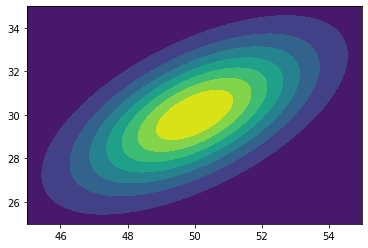

In [4]:
mu = np.array([50., 30.], np.float64)
cov = np.array([[5, 3], [3, 5]], np.float64)
ptial, d_ptial = U(mu, np.linalg.inv(cov)), dU(mu, np.linalg.inv(cov))

X, Y = np.mgrid[45:55:0.078, 25:35:0.078]
pos = np.dstack((X, Y))

gauss = stats.multivariate_normal(mu, cov).pdf(pos)
plt.contourf(X, Y, gauss)
plt.show()

[49.08394575 28.74171421] [4.32248944 3.55266176] 0.9482297163408717
[51.09581249 30.81184762] [4.42533454 3.85777597] 0.940984232191355
[49.37985787 29.85656156] [5.86246288 4.74700092] 0.9433087216794412
[50.19072128 30.01697027] [5.87449872 5.84766841] 0.9377114546667982
[50.15367452 30.17174529] [5.18210069 5.27539286] 0.9355604553474887
[50.4022877  30.43345507] [5.07415013 7.89376733] 0.9312536118522012
[49.62754457 29.73535523] [5.66433385 5.23591434] 0.9344043911885015
[50.19607101 30.2446857 ] [6.06706507 5.91445594] 0.9402789771601013
[50.33156939 30.35684542] [5.66575218 5.76339058] 0.9434994972334076
[50.33451462 30.62825374] [6.30132189 5.09233374] 0.9359589611018798
[49.90935999 30.00348295] [5.24149541 5.27971736] 0.9393715651347777
[50.25401373 29.99641139] [5.41394006 4.87293234] 0.9349154630650696
[50.10151653 29.99457211] [5.94577413 6.55325815] 0.9420144777000528
[49.97125678 29.99583558] [5.58797056 5.89619762] 0.9382533237416425
[49.95221646 29.97902724] [5.589843

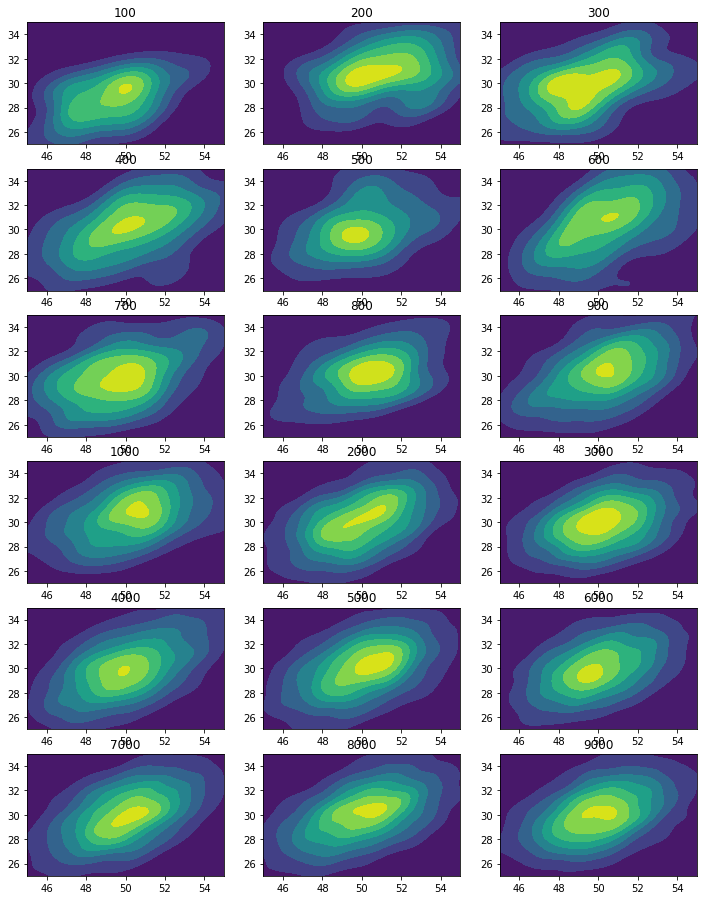

In [9]:
init_func = lambda: mu
tvd = np.array([], np.float64)
plt.figure(figsize=(12,48))
for a, i in enumerate(np.append(np.arange(100, 1000, 100), np.arange(1000, 10000, 1000))):
    samples, acceptance = mala(ptial, d_ptial, init_func, i, 1.2)
    print(np.mean(samples, axis=0), np.var(samples, axis=0), acceptance)
    
    kde = stats.gaussian_kde(samples.T)

    estimate = np.array([kde.evaluate(x) for y in pos for x in y])
    estimate = np.reshape(estimate, (129,129))

    tvd = np.append(tvd, total_variation_distance(estimate, gauss, 0.078))

    plt.subplot(18, 3, a+1)
    plt.title(i)
    plt.contourf(X, Y, estimate)
plt.show()

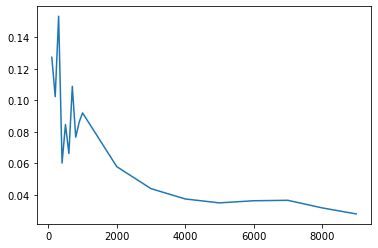

In [6]:
plt.plot(np.append(np.arange(100, 1000, 100), np.arange(1000, 10000, 1000)), tvd)
plt.show()

https://rss.onlinelibrary.wiley.com/doi/full/10.1111/j.1467-9868.2010.00765.x

https://arxiv.org/pdf/1902.08452.pdf

https://en.wikipedia.org/wiki/Brownian_motion#Mathematics